<a href="https://colab.research.google.com/github/human-ai2025/Elo-Merchant-Recommendation/blob/master/Feature%20Engineering/Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
#--------------- DATA HANDLING AND MANIPULATION LIBRARIES ---------------#
import random 
import pandas as pd
import numpy as np
import os
import gc
import pickle
from scipy.stats import uniform, truncnorm, randint
from scipy.stats import randint as sp_randint
import datetime
#---------------                 Warning                  ---------------#
import warnings 
warnings.filterwarnings('ignore')

#---------------        Visualization Libraries           ---------------#
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

#---------------        Machine Learning  Libraries       ---------------#
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import xgboost as xgb

## Memory Reduction Script

In [2]:

#https://www.kaggle.com/fabiendaniel/elo-world
#Function to load data into pandas and reduce memory usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Mount the drive 

In [3]:
#Mounting drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set Path

In [4]:
%cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


## Load Train and Test 

In [5]:
#load train
train = reduce_mem_usage(pd.read_csv('FINAL_TRAIN_M.csv'))
test = reduce_mem_usage(pd.read_csv('FINAL_TEST_M.csv'))

Mem. usage decreased to 99.56 Mb (71.3% reduction)
Mem. usage decreased to 62.01 Mb (70.6% reduction)


## Feature Selection 

Remember not to perform any type of feature selection on Test.

### Check for null values 

In [6]:
train

,Unnamed: 0,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,quarter,elapsed_time,feature_sum,feature_mean,feature_max,feature_min,feature_std,purchase_Year_mode,purchase_Week_sum,purchase_Week_mean,purchase_Week_std,purchase_Day_sum,purchase_Day_mean,purchase_Day_std,purchase_Dayofyear_sum,purchase_Dayofyear_mean,purchase_Dayofyear_std,purchase_Is_month_end_sum,purchase_Is_month_end_mean,purchase_Is_month_end_std,purchase_Is_month_start_sum,purchase_Is_month_start_mean,purchase_Is_month_start_std,purchase_Is_quarter_end_sum,purchase_Is_quarter_end_mean,purchase_Is_quarter_end_std,purchase_Is_quarter_start_sum,purchase_Is_quarter_start_mean,purchase_Is_quarter_start_std,purchase_Is_year_end_sum,purchase_Is_year_end_mean,purchase_Is_year_end_std,...,mer_avg_purchases_lag6_sum,mer_avg_purchases_lag6_mean,mer_avg_purchases_lag6_min,mer_avg_purchases_lag6_max,mer_avg_purchases_lag6_std,mer_avg_purchases_lag12_sum,mer_avg_purchases_lag12_mean,mer_avg_purchases_lag12_min,mer_avg_purchases_lag12_max,mer_avg_purchases_lag12_std,mer_active_months_lag3_sum,mer_active_months_lag3_mean,mer_active_months_lag3_min,mer_active_months_lag3_max,mer_active_months_lag3_std,mer_active_months_lag6_sum,mer_active_months_lag6_mean,mer_active_months_lag6_min,mer_active_months_lag6_max,mer_active_months_lag6_std,mer_active_months_lag12_sum,mer_active_months_lag12_mean,mer_active_months_lag12_min,mer_active_months_lag12_max,mer_active_months_lag12_std,mer_category_1_sum,mer_category_1_mean,mer_category_1_std,mer_most_recent_sales_range_sum,mer_most_recent_sales_range_mean,mer_most_recent_sales_range_std,mer_most_recent_purchases_range_sum,mer_most_recent_purchases_range_mean,mer_most_recent_purchases_range_std,mer_category_4_sum,mer_category_4_mean,mer_category_4_std,mer_category_2_sum,mer_category_2_mean,mer_category_2_std
0,0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,2017,2,1357,8,2.666016,5,1,2.082031,2017,8905,31.468750,15.554688,4411,15.585938,8.804688,61760,218.250,109.1875,9,0.031799,0.175781,7,0.024734,0.155640,5,0.017670,0.131958,3,0.010597,0.102600,1,0.003534,0.059448,...,5484.00,19.437500,0.321045,504.250000,93.312500,6044.00,21.437500,0.252930,554.500000,102.812500,846.0,3.000000,3.0,3.0,0.000000,1691.0,5.996094,5.0,6.0,0.059540,3348.0,11.875000,5.0,12.0,0.794434,258.0,0.915039,0.279541,469.0,1.663086,1.278320,410.0,1.454102,1.288086,16.0,0.056732,0.231812,294.0,1.042969,0.411133
1,1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392822,2017,1,1508,5,1.666992,4,0,2.082031,2017,8881,24.953125,16.703125,5914,16.609375,8.835938,61516,172.750,117.1875,12,0.033722,0.180786,15,0.042145,0.201172,6,0.016861,0.128906,6,0.016861,0.128906,3,0.008430,0.091553,...,1546.00,4.167969,0.307861,504.250000,36.937500,1679.00,4.527344,0.208984,554.500000,40.625000,1113.0,3.000000,3.0,3.0,0.000000,2226.0,6.000000,6.0,6.0,0.000000,4400.0,11.859375,7.0,12.0,0.788574,309.0,0.833008,0.373535,403.0,1.085938,1.363281,397.0,1.070312,1.364258,29.0,0.078186,0.268799,371.0,1.000000,0.000000
2,2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.687988,2016,3,1661,4,1.333008,2,0,1.154297,2017,807,18.343750,13.726562,859,19.515625,7.910156,5572,126.625,96.5000,1,0.022720,0.150757,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,...,61.97,1.376953,0.871094,15.859375,2.208984,62.84,1.396484,0.752441,16.218750,2.261719,135.0,3.000000,3.0,3.0,0.000000,270.0,6.000000,6.0,6.0,0.000000,533.0,11.843750,7.0,12.0,0.796387,43.0,0.955566,0.208374,18.0,0.399902,0.962891,18.0,0.399902,1.008789,3.0,0.066650,0.252197,205.0,4.554688,1.271484
3,3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142456,2017,3,1265,7,2.333984,4,0,2.082031,2017,2562,30.500000,17.140625,1391,16.562500,8.906250,17723,211.000,120.3750,3,0.035706,0.186646,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,...,230.90,2.404297,0.426270,15.859375,4.355469,234.10,2.437500,0.436035,16.218750,4.460938,288.0,3.000000,3.0,3.0,0.000000,576.0,6.000000,6.0,6.0,0.000000,1094.0,11.398438,7.

In [7]:
train.isna().sum()

Unnamed: 0             0
first_active_month     0
card_id                0
feature_1              0
feature_2              0
                      ..
mer_category_4_mean    0
mer_category_4_std     0
mer_category_2_sum     0
mer_category_2_mean    0
mer_category_2_std     0
Length: 225, dtype: int64

In [8]:
#if there are any inf values we will first treat it a nan
train = train.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

In [9]:
train

,Unnamed: 0,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,quarter,elapsed_time,feature_sum,feature_mean,feature_max,feature_min,feature_std,purchase_Year_mode,purchase_Week_sum,purchase_Week_mean,purchase_Week_std,purchase_Day_sum,purchase_Day_mean,purchase_Day_std,purchase_Dayofyear_sum,purchase_Dayofyear_mean,purchase_Dayofyear_std,purchase_Is_month_end_sum,purchase_Is_month_end_mean,purchase_Is_month_end_std,purchase_Is_month_start_sum,purchase_Is_month_start_mean,purchase_Is_month_start_std,purchase_Is_quarter_end_sum,purchase_Is_quarter_end_mean,purchase_Is_quarter_end_std,purchase_Is_quarter_start_sum,purchase_Is_quarter_start_mean,purchase_Is_quarter_start_std,purchase_Is_year_end_sum,purchase_Is_year_end_mean,purchase_Is_year_end_std,...,mer_avg_purchases_lag6_sum,mer_avg_purchases_lag6_mean,mer_avg_purchases_lag6_min,mer_avg_purchases_lag6_max,mer_avg_purchases_lag6_std,mer_avg_purchases_lag12_sum,mer_avg_purchases_lag12_mean,mer_avg_purchases_lag12_min,mer_avg_purchases_lag12_max,mer_avg_purchases_lag12_std,mer_active_months_lag3_sum,mer_active_months_lag3_mean,mer_active_months_lag3_min,mer_active_months_lag3_max,mer_active_months_lag3_std,mer_active_months_lag6_sum,mer_active_months_lag6_mean,mer_active_months_lag6_min,mer_active_months_lag6_max,mer_active_months_lag6_std,mer_active_months_lag12_sum,mer_active_months_lag12_mean,mer_active_months_lag12_min,mer_active_months_lag12_max,mer_active_months_lag12_std,mer_category_1_sum,mer_category_1_mean,mer_category_1_std,mer_most_recent_sales_range_sum,mer_most_recent_sales_range_mean,mer_most_recent_sales_range_std,mer_most_recent_purchases_range_sum,mer_most_recent_purchases_range_mean,mer_most_recent_purchases_range_std,mer_category_4_sum,mer_category_4_mean,mer_category_4_std,mer_category_2_sum,mer_category_2_mean,mer_category_2_std
0,0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820312,2017,2,1357,8,2.666016,5,1,2.082031,2017,8905,31.468750,15.554688,4411,15.585938,8.804688,61760,218.250,109.1875,9,0.031799,0.175781,7,0.024734,0.155640,5,0.017670,0.131958,3,0.010597,0.102600,1,0.003534,0.059448,...,5484.00,19.437500,0.321045,504.250000,93.312500,6044.00,21.437500,0.252930,554.500000,102.812500,846.0,3.000000,3.0,3.0,0.000000,1691.0,5.996094,5.0,6.0,0.059540,3348.0,11.875000,5.0,12.0,0.794434,258.0,0.915039,0.279541,469.0,1.663086,1.278320,410.0,1.454102,1.288086,16.0,0.056732,0.231812,294.0,1.042969,0.411133
1,1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392822,2017,1,1508,5,1.666992,4,0,2.082031,2017,8881,24.953125,16.703125,5914,16.609375,8.835938,61516,172.750,117.1875,12,0.033722,0.180786,15,0.042145,0.201172,6,0.016861,0.128906,6,0.016861,0.128906,3,0.008430,0.091553,...,1546.00,4.167969,0.307861,504.250000,36.937500,1679.00,4.527344,0.208984,554.500000,40.625000,1113.0,3.000000,3.0,3.0,0.000000,2226.0,6.000000,6.0,6.0,0.000000,4400.0,11.859375,7.0,12.0,0.788574,309.0,0.833008,0.373535,403.0,1.085938,1.363281,397.0,1.070312,1.364258,29.0,0.078186,0.268799,371.0,1.000000,0.000000
2,2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.687988,2016,3,1661,4,1.333008,2,0,1.154297,2017,807,18.343750,13.726562,859,19.515625,7.910156,5572,126.625,96.5000,1,0.022720,0.150757,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,...,61.97,1.376953,0.871094,15.859375,2.208984,62.84,1.396484,0.752441,16.218750,2.261719,135.0,3.000000,3.0,3.0,0.000000,270.0,6.000000,6.0,6.0,0.000000,533.0,11.843750,7.0,12.0,0.796387,43.0,0.955566,0.208374,18.0,0.399902,0.962891,18.0,0.399902,1.008789,3.0,0.066650,0.252197,205.0,4.554688,1.271484
3,3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142456,2017,3,1265,7,2.333984,4,0,2.082031,2017,2562,30.500000,17.140625,1391,16.562500,8.906250,17723,211.000,120.3750,3,0.035706,0.186646,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,...,230.90,2.404297,0.426270,15.859375,4.355469,234.10,2.437500,0.436035,16.218750,4.460938,288.0,3.000000,3.0,3.0,0.000000,576.0,6.000000,6.0,6.0,0.000000,1094.0,11.398438,7.

In [10]:
# find the columns o which there are null vales 
train.columns[train.isna().any()]

Index(['mer_avg_purchases_lag3_sum', 'mer_avg_purchases_lag6_sum',
       'mer_avg_purchases_lag12_sum'],
      dtype='object')

In [11]:

def nullValues(df):
  """ Find the columns with null values """
  columns_with_na = [var for var in df.columns if df[var].isnull().mean()  > 0]
  #lets find out the percentage of observations missing per variable

  #calculate the percentage of missing 
  data_na = df[columns_with_na].isnull().mean()

  #transform the array to dataframe 
  data_na = pd.DataFrame(data_na.reset_index())

  #add names to the dataframe 
  data_na.columns = ['col','percentage_na']

  #oreder the dataframe acc to percentage 
  data_na.sort_values(by = 'percentage_na',ascending = False, inplace = True)

  #show
  data_na
  return data_na

In [12]:
print(nullValues(train))

                           col  percentage_na
2  mer_avg_purchases_lag12_sum       0.002135
1   mer_avg_purchases_lag6_sum       0.002125
0   mer_avg_purchases_lag3_sum       0.002035


In [13]:
# As the missing value percentage is very low we will mean impute the values 
train['mer_avg_purchases_lag12_sum'].fillna(train['mer_avg_purchases_lag12_sum'].mean(), inplace=True)
test['mer_avg_purchases_lag12_sum'].fillna(test['mer_avg_purchases_lag12_sum'].mean(), inplace=True)
train['mer_avg_purchases_lag6_sum'].fillna(train['mer_avg_purchases_lag6_sum'].mean(), inplace=True)
test['mer_avg_purchases_lag6_sum'].fillna(test['mer_avg_purchases_lag6_sum'].mean(), inplace=True)
train['mer_avg_purchases_lag3_sum'].fillna(train['mer_avg_purchases_lag3_sum'].mean(), inplace=True)
test['mer_avg_purchases_lag3_sum'].fillna(test['mer_avg_purchases_lag3_sum'].mean(), inplace=True)

In [14]:
print(nullValues(train))

Empty DataFrame
Columns: [col, percentage_na]
Index: []


## Basic Filter methods 

In [15]:
pd.set_option('display.max_columns', 225)
train.head()

,Unnamed: 0,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,quarter,elapsed_time,feature_sum,feature_mean,feature_max,feature_min,feature_std,purchase_Year_mode,purchase_Week_sum,purchase_Week_mean,purchase_Week_std,purchase_Day_sum,purchase_Day_mean,purchase_Day_std,purchase_Dayofyear_sum,purchase_Dayofyear_mean,purchase_Dayofyear_std,purchase_Is_month_end_sum,purchase_Is_month_end_mean,purchase_Is_month_end_std,purchase_Is_month_start_sum,purchase_Is_month_start_mean,purchase_Is_month_start_std,purchase_Is_quarter_end_sum,purchase_Is_quarter_end_mean,purchase_Is_quarter_end_std,purchase_Is_quarter_start_sum,purchase_Is_quarter_start_mean,purchase_Is_quarter_start_std,purchase_Is_year_end_sum,purchase_Is_year_end_mean,purchase_Is_year_end_std,purchase_Is_year_start_sum,purchase_Is_year_start_mean,purchase_Is_year_start_std,purchase_Hour_sum,purchase_Hour_mean,purchase_Hour_std,purchase_Minute_sum,purchase_Minute_mean,purchase_Minute_std,purchase_Second_sum,purchase_Second_mean,purchase_Second_std,purchase_Elapsed_sum,purchase_Elapsed_mean,purchase_Elapsed_std,purchasedWeekday_0_sum,purchasedWeekday_0_mean,purchasedWeekday_0_std,purchasedWeekday_1_sum,purchasedWeekday_1_mean,purchasedWeekday_1_std,purchase_Month_1_sum,purchase_Month_1_mean,purchase_Month_1_std,purchase_Month_2_sum,purchase_Month_2_mean,purchase_Month_2_std,purchase_Month_3_sum,purchase_Month_3_mean,purchase_Month_3_std,purchase_Month_4_sum,purchase_Month_4_mean,purchase_Month_4_std,purchase_Month_5_sum,purchase_Month_5_mean,purchase_Month_5_std,purchase_Month_6_sum,purchase_Month_6_mean,purchase_Month_6_std,purchase_Month_7_sum,purchase_Month_7_mean,purchase_Month_7_std,purchase_Month_8_sum,purchase_Month_8_mean,purchase_Month_8_std,purchase_Month_9_sum,purchase_Month_9_mean,purchase_Month_9_std,purchase_Month_10_sum,purchase_Month_10_mean,purchase_Month_10_std,purchase_Month_11_sum,purchase_Month_11_mean,purchase_Month_11_std,purchase_Month_12_sum,purchase_Month_12_mean,purchase_Month_12_std,purchasedWeekend_0_sum,purchasedWeekend_0_mean,purchasedWeekend_0_std,purchasedWeekend_1_sum,purchasedWeekend_1_mean,purchasedWeekend_1_std,purchase_Dayofweek_0_sum,purchase_Dayofweek_0_mean,purchase_Dayofweek_0_std,purchase_Dayofweek_1_sum,purchase_Dayofweek_1_mean,purchase_Dayofweek_1_std,purchase_Dayofweek_2_sum,purchase_Dayofweek_2_mean,purchase_Dayofweek_2_std,purchase_Dayofweek_3_sum,purchase_Dayofweek_3_mean,purchase_Dayofweek_3_std,purchase_Dayofweek_4_sum,purchase_Dayofweek_4_mean,purchase_Dayofweek_4_std,purchase_Dayofweek_5_sum,purchase_Dayofweek_5_mean,purchase_Dayofweek_5_std,purchase_Dayofweek_6_sum,purchase_Dayofweek_6_mean,purchase_Dayofweek_6_std,purchase_date_temp_period,purchase_date_temp_mean_diff,purchase_date_temp_min,purchase_date_temp_max,monthDiff_period,monthDiff_mean_diff,authorized_flag_sum,authorized_flag_mean,authorized_flag_std,category_1_sum,category_1_mean,category_1_std,category_2_sum,category_2_mean,category_2_std,category_3_sum,category_3_mean,category_3_std,month_lag_sum,month_lag_mean,month_lag_min,month_lag_max,month_lag_std,installments_sum,installments_mean,installments_min,installments_max,installments_std,purchase_amount_sum,purchase_amount_mean,purchase_amount_min,purchase_amount_max,purchase_amount_std,mer_numerical_1_sum,mer_numerical_1_mean,mer_numerical_1_min,mer_numerical_1_max,mer_numerical_1_std,mer_numerical_2_sum,mer_numerical_2_mean,mer_numerical_2_min,mer_numerical_2_max,mer_numerical_2_std,mer_avg_sales_lag3_sum,mer_avg_sales_lag3_mean,mer_avg_sales_lag3_min,mer_avg_sales_lag3_max,mer_avg_sales_lag3_std,mer_avg_sales_lag6_sum,mer_avg_sales_lag6_mean,mer_avg_sales_lag6_std,mer_avg_sales_lag12_sum,mer_avg_sales_lag12_mean,mer_avg_sales_lag12_min,mer_avg_sales_lag12_max,mer_avg_sales_lag12_std,mer_avg_purchases_lag3_sum,mer_avg_purchases_lag3_mean,mer_avg_purchases_lag3_min,mer_avg_purchases_lag3_max,mer_avg_purchases_lag3_std,mer_avg_purchases_lag6_sum,mer_avg_purchases_lag6_mean,mer_avg_purchases_

In [16]:
#drop the unnamed 0
cols = 'Unnamed: 0'
train.drop(cols, axis = 1, inplace = True)

In [17]:
# ignore id based columns and date based columns 
columnsToTake = []
for col in train.columns:
    if col != 'card_id' and col != 'first_active_month' and col != 'target':
        columnsToTake.append(col)

In [18]:
len(columnsToTake)

221

In [19]:
sel = VarianceThreshold(threshold = 0)
sel.fit(train[columnsToTake])

VarianceThreshold(threshold=0)

In [20]:
# get support is a boolean vector that indicates which features are retained 
# if we sum over get_support, we get the umber of features that are not constant
sum(sel.get_support())


219

In [21]:
# Two constant columns 
temp = train[columnsToTake]
[x for x in temp.columns if x not in temp.columns[sel.get_support()]]

['mer_active_months_lag3_max', 'mer_active_months_lag6_max']

In [22]:
temp.mer_active_months_lag3_max.value_counts()/np.float(len(temp))

3.0    1.0
Name: mer_active_months_lag3_max, dtype: float64

In [23]:
temp.mer_active_months_lag6_max.value_counts()/np.float(len(temp))

6.0    1.0
Name: mer_active_months_lag6_max, dtype: float64

In [24]:
def remove_noninformative(df):
    """Remove non-informative columns (all nan, or all same value)"""
    for col in df:
        if df[col].isnull().all():
            print('Removing '+col+' (all NaN)')
            del df[col]
        elif df[col].nunique()<2:
            print('Removing '+col+' (only 1 unique value)')
            del df[col]

remove_noninformative(temp)
gc.collect()

Removing mer_active_months_lag3_max (only 1 unique value)
Removing mer_active_months_lag6_max (only 1 unique value)


0

In [25]:
temp.columns

Index(['feature_1', 'feature_2', 'feature_3', 'year', 'quarter',
       'elapsed_time', 'feature_sum', 'feature_mean', 'feature_max',
       'feature_min',
       ...
       'mer_most_recent_sales_range_std',
       'mer_most_recent_purchases_range_sum',
       'mer_most_recent_purchases_range_mean',
       'mer_most_recent_purchases_range_std', 'mer_category_4_sum',
       'mer_category_4_mean', 'mer_category_4_std', 'mer_category_2_sum',
       'mer_category_2_mean', 'mer_category_2_std'],
      dtype='object', length=219)

In [26]:
len(columnsToTake)

221

In [27]:
# remove those two columns 
for col in columnsToTake:
    if col == 'mer_active_months_lag3_max' or col == 'mer_active_months_lag6_max':
      print("Yes")
      columnsToTake.remove(col)

Yes
Yes


In [28]:
#Now both are same
len(columnsToTake)

219

In [29]:
quaziConstantFeatures = []
for feat in temp.columns:
    pre = (temp[feat].value_counts()/np.float(
    len(temp))).sort_values(ascending = False).values[0]
    
    if pre > 0.99:
        quaziConstantFeatures.append(feat)
len(quaziConstantFeatures)

3

In [30]:
quaziConstantFeatures

['mer_numerical_1_min', 'mer_numerical_2_min', 'mer_active_months_lag12_max']

In [31]:
temp.mer_numerical_1_min.value_counts()/np.float(len(temp))

-0.057465     0.991967
-0.047546     0.003853
-0.037628     0.001332
-0.027725     0.000797
-0.017807     0.000287
                ...   
 0.220093     0.000005
 20.500000    0.000005
 0.755371     0.000005
 7.152344     0.000005
 1.003906     0.000005
Name: mer_numerical_1_min, Length: 106, dtype: float64

In [32]:
temp.mer_numerical_2_min.value_counts()/np.float(len(temp))

-0.057465    0.997519
-0.047546    0.001030
-0.027725    0.000426
-0.037628    0.000406
-0.017807    0.000074
               ...   
 0.160645    0.000005
 0.755371    0.000005
 0.448242    0.000005
 2.599609    0.000005
 6.894531    0.000005
Name: mer_numerical_2_min, Length: 83, dtype: float64

In [33]:
temp.mer_active_months_lag12_max.value_counts()/np.float(len(temp))

12.0    0.999802
10.0    0.000183
11.0    0.000005
8.0     0.000005
9.0     0.000005
Name: mer_active_months_lag12_max, dtype: float64

In [34]:
for col in columnsToTake:
    if col in quaziConstantFeatures:
        columnsToTake.remove(col)

In [35]:
len(columnsToTake)

216

In [36]:
# for duplicate features 
duplicatedFeat = []
for i in range(0, len(columnsToTake)):
    
    if i % 10 == 0:
        print(i)
        
    col1 = temp.columns[i]
    
    for col2 in temp.columns[i + 1:]:
        if temp[col1].equals(temp[col2]):
            print(col1)
            print(col2)
            duplicatedFeat.append(col2)

0
feature_3
feature_min
10
20
30
40
50
purchasedWeekday_0_sum
purchasedWeekend_1_sum
purchasedWeekday_0_mean
purchasedWeekend_1_mean
purchasedWeekday_0_std
purchasedWeekday_1_std
purchasedWeekday_0_std
purchasedWeekend_0_std
purchasedWeekday_0_std
purchasedWeekend_1_std
purchasedWeekday_1_sum
purchasedWeekend_0_sum
purchasedWeekday_1_mean
purchasedWeekend_0_mean
purchasedWeekday_1_std
purchasedWeekend_0_std
purchasedWeekday_1_std
purchasedWeekend_1_std
60
70
80
90
purchasedWeekend_0_std
purchasedWeekend_1_std
100
110
120
130
140
150
160
170
180
190
200
210


In [37]:
duplicatedFeat

['feature_min',
 'purchasedWeekend_1_sum',
 'purchasedWeekend_1_mean',
 'purchasedWeekday_1_std',
 'purchasedWeekend_0_std',
 'purchasedWeekend_1_std',
 'purchasedWeekend_0_sum',
 'purchasedWeekend_0_mean',
 'purchasedWeekend_0_std',
 'purchasedWeekend_1_std',
 'purchasedWeekend_1_std']

In [38]:
for col in columnsToTake:
    if col in duplicatedFeat:
        columnsToTake.remove(col)

In [39]:
len(columnsToTake)

211

## Correlation 

In [40]:
temp = temp[columnsToTake]
temp

,feature_1,feature_2,feature_3,year,quarter,elapsed_time,feature_sum,feature_mean,feature_max,feature_std,purchase_Year_mode,purchase_Week_sum,purchase_Week_mean,purchase_Week_std,purchase_Day_sum,purchase_Day_mean,purchase_Day_std,purchase_Dayofyear_sum,purchase_Dayofyear_mean,purchase_Dayofyear_std,purchase_Is_month_end_sum,purchase_Is_month_end_mean,purchase_Is_month_end_std,purchase_Is_month_start_sum,purchase_Is_month_start_mean,purchase_Is_month_start_std,purchase_Is_quarter_end_sum,purchase_Is_quarter_end_mean,purchase_Is_quarter_end_std,purchase_Is_quarter_start_sum,purchase_Is_quarter_start_mean,purchase_Is_quarter_start_std,purchase_Is_year_end_sum,purchase_Is_year_end_mean,purchase_Is_year_end_std,purchase_Is_year_start_sum,purchase_Is_year_start_mean,purchase_Is_year_start_std,purchase_Hour_sum,purchase_Hour_mean,purchase_Hour_std,purchase_Minute_sum,purchase_Minute_mean,purchase_Minute_std,purchase_Second_sum,purchase_Second_mean,purchase_Second_std,purchase_Elapsed_sum,purchase_Elapsed_mean,purchase_Elapsed_std,purchasedWeekday_0_sum,purchasedWeekday_0_mean,purchasedWeekday_0_std,purchasedWeekday_1_sum,purchasedWeekday_1_mean,purchase_Month_1_sum,purchase_Month_1_mean,purchase_Month_1_std,purchase_Month_2_sum,purchase_Month_2_mean,purchase_Month_2_std,purchase_Month_3_sum,purchase_Month_3_mean,purchase_Month_3_std,purchase_Month_4_sum,purchase_Month_4_mean,purchase_Month_4_std,purchase_Month_5_sum,purchase_Month_5_mean,purchase_Month_5_std,purchase_Month_6_sum,purchase_Month_6_mean,purchase_Month_6_std,purchase_Month_7_sum,purchase_Month_7_mean,purchase_Month_7_std,purchase_Month_8_sum,purchase_Month_8_mean,purchase_Month_8_std,purchase_Month_9_sum,purchase_Month_9_mean,purchase_Month_9_std,purchase_Month_10_sum,purchase_Month_10_mean,purchase_Month_10_std,purchase_Month_11_sum,purchase_Month_11_mean,purchase_Month_11_std,purchase_Month_12_sum,purchase_Month_12_mean,purchase_Month_12_std,purchasedWeekend_0_mean,purchasedWeekend_1_sum,purchasedWeekend_1_std,purchase_Dayofweek_0_sum,purchase_Dayofweek_0_mean,purchase_Dayofweek_0_std,purchase_Dayofweek_1_sum,purchase_Dayofweek_1_mean,purchase_Dayofweek_1_std,purchase_Dayofweek_2_sum,purchase_Dayofweek_2_mean,purchase_Dayofweek_2_std,purchase_Dayofweek_3_sum,purchase_Dayofweek_3_mean,purchase_Dayofweek_3_std,purchase_Dayofweek_4_sum,purchase_Dayofweek_4_mean,purchase_Dayofweek_4_std,purchase_Dayofweek_5_sum,purchase_Dayofweek_5_mean,purchase_Dayofweek_5_std,purchase_Dayofweek_6_sum,purchase_Dayofweek_6_mean,purchase_Dayofweek_6_std,purchase_date_temp_period,purchase_date_temp_mean_diff,purchase_date_temp_min,purchase_date_temp_max,monthDiff_period,monthDiff_mean_diff,authorized_flag_sum,authorized_flag_mean,authorized_flag_std,category_1_sum,category_1_mean,category_1_std,category_2_sum,category_2_mean,category_2_std,category_3_sum,category_3_mean,category_3_std,month_lag_sum,month_lag_mean,month_lag_min,month_lag_max,month_lag_std,installments_sum,installments_mean,installments_min,installments_max,installments_std,purchase_amount_sum,purchase_amount_mean,purchase_amount_min,purchase_amount_max,purchase_amount_std,mer_numerical_1_sum,mer_numerical_1_mean,mer_numerical_1_max,mer_numerical_1_std,mer_numerical_2_sum,mer_numerical_2_mean,mer_numerical_2_max,mer_numerical_2_std,mer_avg_sales_lag3_sum,mer_avg_sales_lag3_mean,mer_avg_sales_lag3_min,mer_avg_sales_lag3_max,mer_avg_sales_lag3_std,mer_avg_sales_lag6_sum,mer_avg_sales_lag6_mean,mer_avg_sales_lag6_std,mer_avg_sales_lag12_sum,mer_avg_sales_lag12_mean,mer_avg_sales_lag12_min,mer_avg_sales_lag12_max,mer_avg_sales_lag12_std,mer_avg_purchases_lag3_sum,mer_avg_purchases_lag3_mean,mer_avg_purchases_lag3_min,mer_avg_purchases_lag3_max,mer_avg_purchases_lag3_std,mer_avg_purchases_lag6_sum,mer_avg_purchases_lag6_mean,mer_avg_purchases_lag6_min,mer_avg_purchases_lag6_max,mer_avg_purchases_lag6_std,mer_avg_purchases_lag12_sum,mer_avg_purchases_lag12_mean,mer_avg_purchases_lag12_min,mer_avg_purchases_lag12_max,mer_avg_purcha

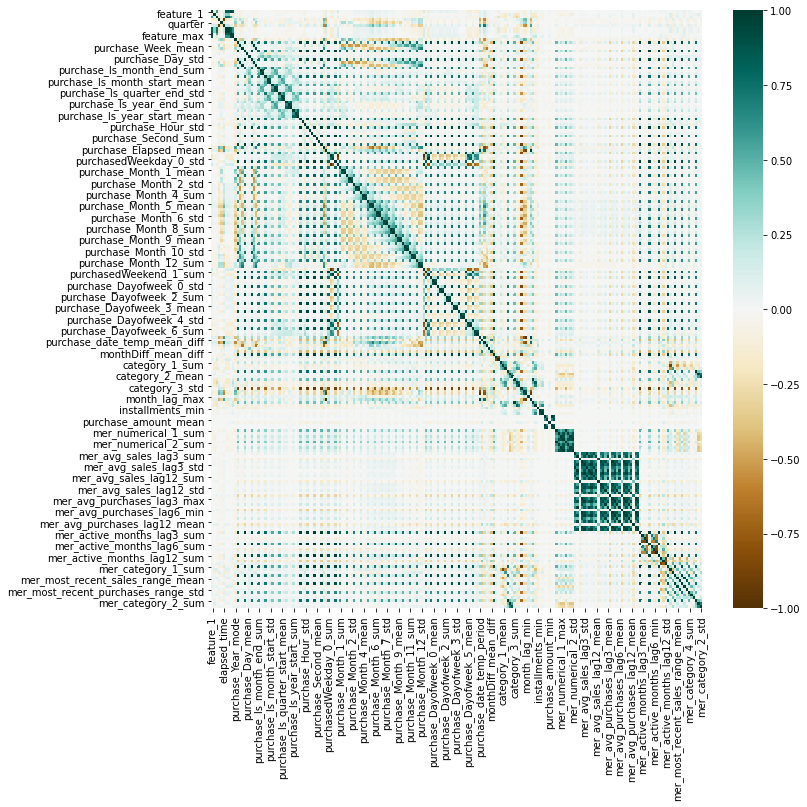

In [41]:
corr = temp.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corr, vmin=-1, vmax=1, cmap='BrBG')

In [42]:
# lets find the correlated features 

def correlation(df, theta):
    """
        Finds the correlated features
        ---------------------------------------------------------
        Args:
            df:- The dataframe on which we need to perform correlation analysis
            theta:-  The threshold of the correlation 
        ---------------------------------------------------------
        Returns:
                The correlated values  
        ---------------------------------------------------------
        Author:- Tarini Tanaya Mohapatra 
        
    """
    col_corr = set() #so no other duplicate values 
    corr_matrix = df.corr()
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > theta:
                colName = corr_matrix.columns[i]
                col_corr.add(colName)
    return col_corr

In [43]:
corr_features = correlation(temp, 0.85)
len(set(corr_features))

100

In [44]:
corrmat = temp.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef
corrmat = corrmat.sort_values(ascending = False)
corrmat = corrmat[corrmat >= 0.85]
corrmat = corrmat[corrmat<1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr
0,feature_mean,feature_sum,1.000000
1,feature_sum,feature_mean,1.000000
2,purchasedWeekday_0_mean,purchasedWeekday_1_mean,0.999999
3,purchasedWeekday_0_mean,purchasedWeekend_0_mean,0.999999
4,purchasedWeekday_1_mean,purchasedWeekday_0_mean,0.999999


In [45]:
corrmat

,feature1,feature2,corr
0,feature_mean,feature_sum,1.000000
1,feature_sum,feature_mean,1.000000
2,purchasedWeekday_0_mean,purchasedWeekday_1_mean,0.999999
3,purchasedWeekday_0_mean,purchasedWeekend_0_mean,0.999999
4,purchasedWeekday_1_mean,purchasedWeekday_0_mean,0.999999
...,...,...,...
837,mer_avg_sales_lag6_std,mer_avg_purchases_lag12_max,0.851584
838,month_lag_sum,purchase_Dayofweek_0_sum,0.851508
839,purchase_Dayofweek_0_sum,month_lag_sum,0.851508
840,month_lag_sum,purchase_Week_sum,0.850899


In [46]:
#find the groups of correlated features 
grouped_feature_ls = []
correlated_groups = []


for feature in corrmat["feature1"].unique():
    if feature not in grouped_feature_ls:
        
        # find all correlated features to a single feature 
        correlated_block = corrmat[corrmat['feature1'] == feature]
        grouped_feeature_ls = grouped_feature_ls + list(
        correlated_block['feature2'].unique()) + [feature]
        
        #append the block of features to the list 
        correlated_groups.append(correlated_block)
        
print('Found {} correlated groups'.format(len(correlated_groups)))
print('Out of {} total features '.format(temp.shape[1]))


Found 153 correlated groups
Out of 211 total features 


In [47]:
i = 0
for group in correlated_groups:
    i += 1
    print("The group ", i)
    print(group)
    print()

The group  1
       feature1     feature2  corr
0  feature_mean  feature_sum   1.0

The group  2
      feature1      feature2  corr
1  feature_sum  feature_mean   1.0

The group  3
                  feature1                 feature2      corr
2  purchasedWeekday_0_mean  purchasedWeekday_1_mean  0.999999
3  purchasedWeekday_0_mean  purchasedWeekend_0_mean  0.999999

The group  4
                  feature1                 feature2      corr
4  purchasedWeekday_1_mean  purchasedWeekday_0_mean  0.999999

The group  5
                  feature1                 feature2      corr
5  purchasedWeekend_0_mean  purchasedWeekday_0_mean  0.999999

The group  6
                       feature1                             feature2      corr
6    mer_active_months_lag3_sum           mer_active_months_lag6_sum  0.999998
21   mer_active_months_lag3_sum          mer_active_months_lag12_sum  0.999768
30   mer_active_months_lag3_sum                 purchase_Elapsed_sum  0.998470
53   mer_active_months_lag3

In [48]:
#make y_train 
y_train = train.target
y_train

0        -0.820312
1         0.392822
2         0.687988
3         0.142456
4        -0.159790
            ...   
201912   -2.740234
201913    0.312988
201914    0.093506
201915   -4.675781
201916   -1.859375
Name: target, Length: 201917, dtype: float16

In [49]:

def deleteColumns(i):
    """
        To remove correlated features and keep the highest important feature of the group
        We use xgbregressor 
        ----------------------------------------------
        Args:
            i:-  Group no
        -----------------------------------------------
        Returns:
            none
        ------------------------------------------------
        Author: Tarini Tanaya Mohapatra 
    
    """
    print(correlated_groups[i].feature1.value_counts().index.values)
    features = list(correlated_groups[i]['feature2'].unique()) + correlated_groups[i].feature1.value_counts().index.values.tolist()
    columns_removal = list(correlated_groups[i]['feature2'].unique()) + correlated_groups[i].feature1.value_counts().index.values.tolist()
    print("The features are ",features)
    rf = xgb.XGBRegressor(objective= 'reg:squarederror')
    rf.fit(train[features], y_train)
    importance = pd.concat(
                        [pd.Series(features),
                        pd.Series(rf.feature_importances_)], axis = 1)
    
    importance.columns = ['feature1', 'importance']
    importance.sort_values(by = 'importance', ascending = False, inplace = True)
    importance.reset_index(inplace = True,drop=True)
    
    columns_removal.remove(importance.feature1[0])
    print("The important feature is ",importance.feature1[0])
    print("The columns to remove ")
    print(columns_removal)
    for col in columnsToTake:
        if col in columns_removal:
            columnsToTake.remove(col)

    print(len(columnsToTake))


In [50]:
# for 153 groups
for i in range(152):
    print("Group ",i)
    deleteColumns(i)

Group  0
['feature_mean']
The features are  ['feature_sum', 'feature_mean']
The important feature is  feature_sum
The columns to remove 
['feature_mean']
210
Group  1
['feature_sum']
The features are  ['feature_mean', 'feature_sum']
The important feature is  feature_mean
The columns to remove 
['feature_sum']
209
Group  2
['purchasedWeekday_0_mean']
The features are  ['purchasedWeekday_1_mean', 'purchasedWeekend_0_mean', 'purchasedWeekday_0_mean']
The important feature is  purchasedWeekday_0_mean
The columns to remove 
['purchasedWeekday_1_mean', 'purchasedWeekend_0_mean']
207
Group  3
['purchasedWeekday_1_mean']
The features are  ['purchasedWeekday_0_mean', 'purchasedWeekday_1_mean']
The important feature is  purchasedWeekday_1_mean
The columns to remove 
['purchasedWeekday_0_mean']
206
Group  4
['purchasedWeekend_0_mean']
The features are  ['purchasedWeekday_0_mean', 'purchasedWeekend_0_mean']
The important feature is  purchasedWeekend_0_mean
The columns to remove 
['purchasedWeekday

In [51]:
# So we have 89 columns now after basic feature selection 
columnsToTake

['feature_2',
 'feature_3',
 'quarter',
 'elapsed_time',
 'purchase_Year_mode',
 'purchase_Day_mean',
 'purchase_Day_std',
 'purchase_Dayofyear_mean',
 'purchase_Dayofyear_std',
 'purchase_Is_month_end_sum',
 'purchase_Is_month_start_sum',
 'purchase_Is_month_start_mean',
 'purchase_Is_month_start_std',
 'purchase_Is_quarter_end_sum',
 'purchase_Is_quarter_start_sum',
 'purchase_Is_year_end_sum',
 'purchase_Is_year_end_std',
 'purchase_Is_year_start_sum',
 'purchase_Hour_mean',
 'purchase_Hour_std',
 'purchase_Minute_mean',
 'purchase_Minute_std',
 'purchase_Second_mean',
 'purchase_Second_std',
 'purchase_Elapsed_mean',
 'purchasedWeekday_0_std',
 'purchase_Month_1_sum',
 'purchase_Month_1_std',
 'purchase_Month_2_sum',
 'purchase_Month_2_std',
 'purchase_Month_3_sum',
 'purchase_Month_3_mean',
 'purchase_Month_4_sum',
 'purchase_Month_5_sum',
 'purchase_Month_6_sum',
 'purchase_Month_7_sum',
 'purchase_Month_8_sum',
 'purchase_Month_9_sum',
 'purchase_Month_10_sum',
 'purchase_Month_

In [52]:
#lets save the columns to take in a pickle file 
pickle.dump(columnsToTake,open('columnsToTake.pkl','wb'))
columnsToTake = pickle.load(open("columnsToTake.pkl", 'rb')) 